In [ ]:
!pip install -q ultralytics kaggle pyyaml tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 32.5 MB/s eta 0:00:00


In [ ]:
from google.colab import files
files.upload()  # <-- upload kaggle.json here

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

# Download + unzip C2A
!kaggle datasets download -d rgbnihal/c2a-dataset -p /content
!unzip -q -o /content/c2a-dataset.zip -d /content/c2a

# Quick peek
!ls -R /content/c2a | head -n 200


TypeError: 'NoneType' object is not subscriptable

In [ ]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="qfJAKBQ8epnHnKRr7S8Q")
project = rf.workspace("spyrobot").project("fire-smoke-and-human-detector")
version = project.version(32)   # v32 of the dataset
dataset = version.download("yolov8")


loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Fire-Smoke-and-Human-Detector-32 in yolov8:: 100%|██████████| 19510/19510 [00:05<00:00, 3800.00it/s]


In [ ]:
import glob

c2a_labels = glob.glob("/content/c2a/**/*.txt", recursive=True)

for label_file in c2a_labels:
    new_lines = []
    with open(label_file, "r") as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) >= 5 and parts[0].isdigit():
                cls = int(parts[0])
                if cls == 0:   # 0 in C2A = human
                    parts[0] = "1"  # remap to 'human' = class 1 in Roboflow
                    new_lines.append(" ".join(parts) + "\n")
    with open(label_file, "w") as f:
        f.writelines(new_lines)


In [ ]:
import os, shutil, glob

# Paths from your setup
C2A_PATH = "/content/c2a"   # after unzip
RF_PATH = "/content/Fire-Smoke-and-Human-Detector-32"  # roboflow download
MERGED_PATH = "/content/merged_dataset"

# 1️⃣ Make directories
for split in ["train", "val", "test"]:
    for sub in ["images", "labels"]:
        os.makedirs(os.path.join(MERGED_PATH, split, sub), exist_ok=True)

# 2️⃣ Copy Roboflow dataset (fire/smoke/human, already YOLO format)
for split in ["train", "valid", "test"]:
    dst_split = "val" if split == "valid" else split
    for sub in ["images", "labels"]:
        src = os.path.join(RF_PATH, split, sub)
        dst = os.path.join(MERGED_PATH, dst_split, sub)
        if os.path.exists(src):
            for f in glob.glob(os.path.join(src, "*")):
                shutil.copy(f, dst)

print("✅ Copied Roboflow dataset")

# 3️⃣ Copy + remap C2A dataset (only humans → class 1)
c2a_splits = {
    "train": "train",
    "test": "val"  # treat test as val
}

for split, dst_split in c2a_splits.items():
    img_dir = os.path.join(C2A_PATH, "C2A_Dataset", "new_dataset3", split, "images")
    lbl_dir = os.path.join(C2A_PATH, "C2A_Dataset", "new_dataset3", split, "labels")

    for img_file in glob.glob(os.path.join(img_dir, "*")):
        shutil.copy(img_file, os.path.join(MERGED_PATH, dst_split, "images"))

    for lbl_file in glob.glob(os.path.join(lbl_dir, "*")):
        with open(lbl_file, "r") as f:
            lines = f.readlines()

        new_lines = []
        for line in lines:
            parts = line.strip().split()
            if not parts:
                continue
            cls = int(parts[0])
            if cls == 0:  # original C2A human
                parts[0] = "1"  # map to 'human' (class 1 in merged dataset)
                new_lines.append(" ".join(parts) + "\n")

        if new_lines:
            with open(os.path.join(MERGED_PATH, dst_split, "labels", os.path.basename(lbl_file)), "w") as f:
                f.writelines(new_lines)

print("✅ Copied + remapped C2A dataset")

# 4️⃣ Write merged YAML
merged_yaml = """train: /content/merged_dataset/train/images
val: /content/merged_dataset/val/images
test: /content/merged_dataset/test/images

nc: 3
names: ["fire", "human", "smoke"]
"""

with open(os.path.join(MERGED_PATH, "data.yaml"), "w") as f:
    f.write(merged_yaml)

print("✅ Merged data.yaml created at", os.path.join(MERGED_PATH, "data.yaml"))


✅ Copied Roboflow dataset
✅ Copied + remapped C2A dataset
✅ Merged data.yaml created at /content/merged_dataset/data.yaml


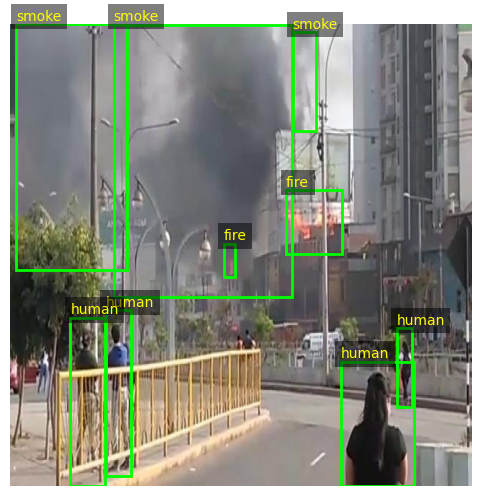

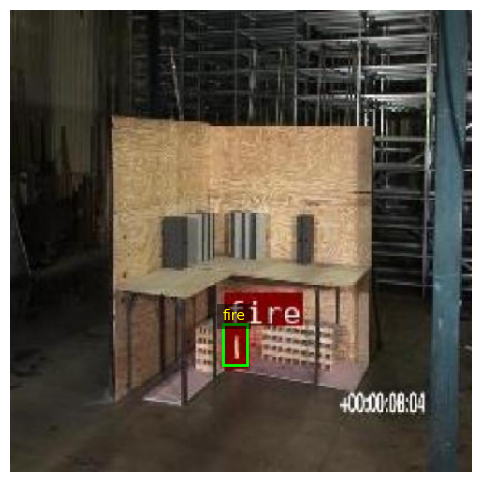

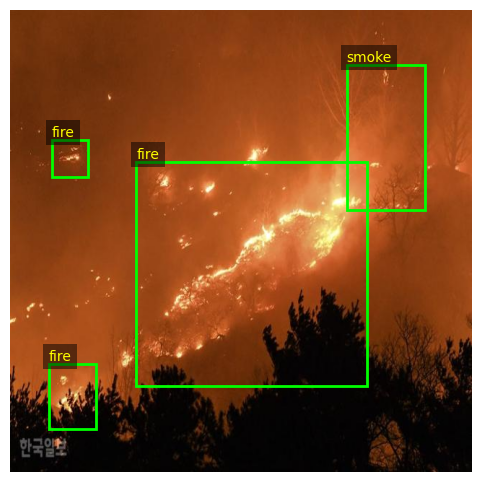

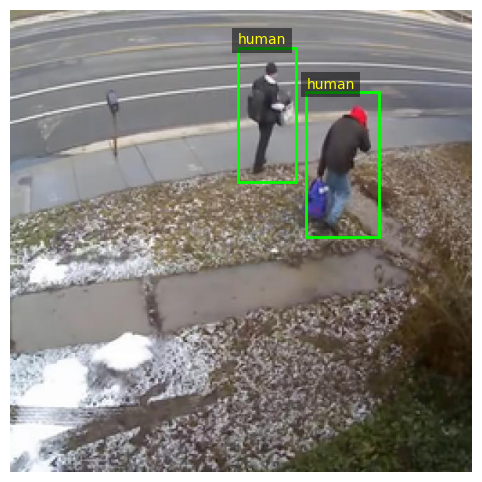

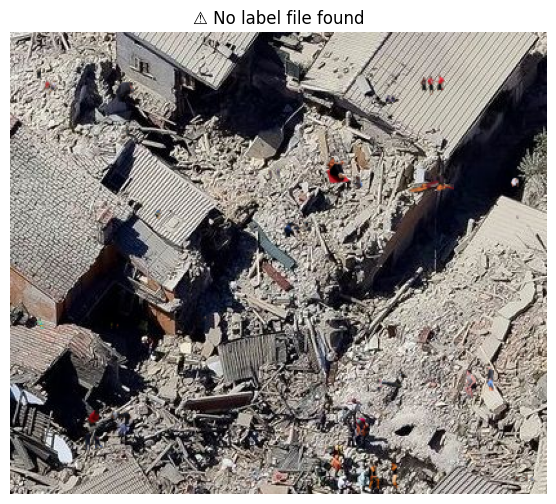

In [ ]:
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import yaml

# Load class names from merged data.yaml
with open("/content/merged_dataset/data.yaml", "r") as f:
    data_cfg = yaml.safe_load(f)
class_names = data_cfg["names"]

# Pick random images from merged dataset
IMG_DIR = "/content/merged_dataset/train/images"
img_files = glob.glob(os.path.join(IMG_DIR, "*"))
sampled_imgs = random.sample(img_files, 5)

def plot_image_with_labels(img_path):
    lbl_path = img_path.replace("images", "labels").rsplit(".", 1)[0] + ".txt"

    img = plt.imread(img_path)
    fig, ax = plt.subplots(1, figsize=(8, 6))
    ax.imshow(img)
    h, w = img.shape[:2]

    if os.path.exists(lbl_path):
        with open(lbl_path, "r") as f:
            for line in f.readlines():
                cls, x, y, bw, bh = map(float, line.strip().split())
                cls = int(cls)
                # Convert YOLO format (cx,cy,bw,bh) to rect
                x1 = (x - bw/2) * w
                y1 = (y - bh/2) * h
                box_w = bw * w
                box_h = bh * h

                rect = patches.Rectangle((x1, y1), box_w, box_h,
                                         linewidth=2, edgecolor='lime', facecolor='none')
                ax.add_patch(rect)
                ax.text(x1, y1-5, class_names[cls], color='yellow',
                        bbox=dict(facecolor='black', alpha=0.5, edgecolor='none'))
    else:
        ax.set_title("⚠️ No label file found")

    plt.axis("off")
    plt.show()

# Show 5 random examples
for img_path in sampled_imgs:
    plot_image_with_labels(img_path)


In [ ]:
from ultralytics import YOLO

# Load small YOLOv8 model
model = YOLO("yolov8s.pt")

# Train
model.train(
    data="/content/merged_dataset/data.yaml",
    epochs=30,              # increase if you want more accuracy
    imgsz=640,              # typical input size
    batch=16,               # adjust if Colab runs out of memory
    workers=2,
    device=0                # 0 = GPU
)

Ultralytics 8.3.189 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/merged_dataset/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pretrain

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7a551395f410>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!cp /content/runs/detect/train/weights/best.pt /content/drive/MyDrive/
!cp /content/runs/detect/train/weights/last.pt /content/drive/MyDrive/


Mounted at /content/drive


In [ ]:
from google.colab import files

uploaded = files.upload()  # choose best.pt and last.pt

Saving Quick-thinking driver races burning truck to fire station.mp4 to Quick-thinking driver races burning truck to fire station.mp4


In [ ]:
!mkdir -p /content/weights
!mv /content/best.pt /content/weights/
!mv /content/last.pt /content/weights/

In [ ]:
from ultralytics import YOLO
import cv2

# Load your trained model (best.pt or last.pt)
model = YOLO("best.pt")   # or "last.pt"

# Run prediction on the uploaded video
results = model.predict(source="test.mp4", save=True, conf=0.5)

print("✅ Inference complete. Check the runs/detect/predict directory for output video.")



WARNING ⚠️ 
inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

video 1/1 (frame 1/1804) /content/test.mp4: 384x640 (no detections), 198.1ms
video 1/1 (frame 2/1804) /content/test.mp4: 384x640 (no detections), 12.0ms
video 1/1 (frame 3/1804) /content/test.mp4: 384x640 (no detections), 18.2ms
video 1/1 (frame 4/1804) /content/test.mp4: 384x640 (no detections), 16.0ms
video 1/1 (frame 5/1804) /content/test.mp4: 384x640 (no detections), 10.7ms
video 1/1 (frame 6/1804) /content/test.mp4: 384x640 (no detections), 10.8ms

In [ ]:
import cv2

# Convert AVI → MP4
input_path = "runs/detect/predict/test.avi"
output_path = "runs/detect/predict/test.mp4"

cap = cv2.VideoCapture(input_path)
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
fps = cap.get(cv2.CAP_PROP_FPS)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    out.write(frame)

cap.release()
out.release()
files.download("runs/detect/predict/test.mp4")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>